# <center>ICLR Peer Review in Multiclass Classification Model<br>(Linear SVC & Logistic Regression)<center>

### <center>Chan Soraneat Chanthan<br>COMP-1804 Applied Machine Learning<br>001194686<center>

### Below represent four main parts:
1. Exclusion Dataframe
2. Multiclass Classification to Implement Acceptance Status
3. Multiclass Classification to Implement Review Score
4. Multiclass Classification to Implement Review Score (Another Implement Way)

# 1. Exclusion Dataframe

## Loading Dataset

In [1]:
# Import all the needed packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import en_core_web_sm
import string

# Package needed
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [2]:
# Read the csv orignal file dataset 
PRW=pd.read_csv("processed_reviews_split_surnamesABCD_minimal.csv")
# Display the first 5 rows of the dataset
PRW.head(5)

,review_id,text,confidence_score,review_score,acceptance_status
0,iclr_review_0000,Predicting Medications from Diagnostic Codes w...,3.0,6.0,Accept
1,iclr_review_0001,Unrestricted Adversarial Examples via Semantic...,NaN,6.0,Accept
2,iclr_review_0002,#. #. #. #,NaN,6.0,Accept
3,iclr_review_0003,Sufficient Conditions for Robustness to Advers...,3.0,5.0,Reject
4,iclr_review_0004,Unsupervised Learning of the Set of Local Maxi...,3.0,8.0,Accept


In [3]:
# Display the shape of the entire dataset
PRW.shape

(6119, 5)

## Manage Data for the Exclusion CSV File

In [4]:
# Sorting the data based on review_id
Sort_PRW = PRW.sort_values("review_id", axis=0, na_position="last")
# Find and Drop the duplicate data based on the three features
PRW1 = Sort_PRW.drop_duplicates(subset=["review_id","text","review_score"])
# Display the data after remove duplicates
print("Shape of the data after remove duplicates {}".format(PRW1.shape[0]))

Shape of the data after remove duplicates 6119


In [5]:
#Check if the data has any null values (Missing value)
PRW1.isnull().sum()

review_id               0
text                   84
confidence_score     2801
review_score            0
acceptance_status     390
dtype: int64

In [6]:
# Find and Display the data that missing value
NDT = PRW1[PRW1.isnull().any(axis=1)]
NDT

,review_id,text,confidence_score,review_score,acceptance_status
1,iclr_review_0001,Unrestricted Adversarial Examples via Semantic...,NaN,6.0,Accept
2,iclr_review_0002,#. #. #. #,NaN,6.0,Accept
7,iclr_review_0007,Neural-Guided Symbolic Regression with Asympto...,NaN,8.0,Reject
8,iclr_review_0008,Lazy-CFR: fast and near-optimal regret minimiz...,NaN,8.0,Accept
9,iclr_review_0009,Learning Functionally Decomposed Hierarchies f...,NaN,6.0,Reject
...,...,...,...,...,...
6106,iclr_review_6106,Economy Statistical Recurrent Units For Inferr...,NaN,6.0,Accept
6107,iclr_review_6107,Depth-Recurrent Residual Connections for Super...,NaN,3.0,NaN
6110,iclr_review_6110,When Covariate-shifted Data Augmentation Incre...,NaN,6.0,Reject
6115,iclr_review_6115,Wasserstein Robust Reinforcement Learning. Rei...,NaN,3.0,Reject


In [7]:
# Take only data_id for the exclusion dataframe
NDT = NDT[['review_id']]
NDT = NDT.rename(columns={'review_id': 'data_id'})
NDT.head(5)

,data_id
1,iclr_review_0001
2,iclr_review_0002
7,iclr_review_0007
8,iclr_review_0008
9,iclr_review_0009


In [8]:
# Add the new column "excluded" all value 1, which mean was excluded
NDT["excluded"]=1
NDT.head(5)

,data_id,excluded
1,iclr_review_0001,1
2,iclr_review_0002,1
7,iclr_review_0007,1
8,iclr_review_0008,1
9,iclr_review_0009,1


In [9]:
# Add the new column "reasion_for_exclusion" all value "Missing_value"
NDT["reason_for_exclusion"] = "Missing_value"
NDT

,data_id,excluded,reason_for_exclusion
1,iclr_review_0001,1,Missing_value
2,iclr_review_0002,1,Missing_value
7,iclr_review_0007,1,Missing_value
8,iclr_review_0008,1,Missing_value
9,iclr_review_0009,1,Missing_value
...,...,...,...
6106,iclr_review_6106,1,Missing_value
6107,iclr_review_6107,1,Missing_value
6110,iclr_review_6110,1,Missing_value
6115,iclr_review_6115,1,Missing_value


In [10]:
# Create a csv file named "exclusions_dataset_task1.csv" for the exclusion dataframe
NDT.to_csv('exclusions_dataset_task1.csv', index = False)

# 2. Multiclass Classification to Implement Acceptance Status

## Dataset Analysis

In [11]:
# Display the orginal dataset
PRW

,review_id,text,confidence_score,review_score,acceptance_status
0,iclr_review_0000,Predicting Medications from Diagnostic Codes w...,3.0,6.0,Accept
1,iclr_review_0001,Unrestricted Adversarial Examples via Semantic...,NaN,6.0,Accept
2,iclr_review_0002,#. #. #. #,NaN,6.0,Accept
3,iclr_review_0003,Sufficient Conditions for Robustness to Advers...,3.0,5.0,Reject
4,iclr_review_0004,Unsupervised Learning of the Set of Local Maxi...,3.0,8.0,Accept
...,...,...,...,...,...
6114,iclr_review_6114,PixelNN: Example-based Image Synthesis. We pre...,3.0,7.0,Accept
6115,iclr_review_6115,Wasserstein Robust Reinforcement Learning. Rei...,NaN,3.0,Reject
6116,iclr_review_6116,Learning to Augment Influential Data. Data aug...,4.0,6.0,Reject
6117,iclr_review_6117,The Incredible Shrinking Neural Network: New P...,4.0,3.0,Reject


In [12]:
# Check the basic information of the dataset
PRW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6119 entries, 0 to 6118
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          6119 non-null   object 
 1   text               6035 non-null   object 
 2   confidence_score   3318 non-null   float64
 3   review_score       6119 non-null   float64
 4   acceptance_status  5729 non-null   object 
dtypes: float64(2), object(3)
memory usage: 239.1+ KB


In [13]:
# Check for the data structure
PRW.describe()

,confidence_score,review_score
count,3318.000000,6119.000000
mean,3.795057,4.689492
std,0.815260,2.192145
min,1.000000,-1.000000
25%,3.000000,3.000000
50%,4.000000,5.000000
75%,4.000000,6.000000
max,5.000000,10.000000


## Data Cleaning

In [14]:
# Sorting the data based on review_id
Sort_PRW = PRW.sort_values("review_id", axis=0, na_position="last")
# Find and Drop the duplicate data based on the three features
PRW = Sort_PRW.drop_duplicates(subset=["review_id","text","review_score"])
# Display the data after remove duplicates
print("Shape of the data after remove duplicates {}".format(PRW1.shape[0]))

Shape of the data after remove duplicates 6119


In [15]:
# Check if the data has any null values (Missing value)
PRW.isnull().sum()

review_id               0
text                   84
confidence_score     2801
review_score            0
acceptance_status     390
dtype: int64

In [16]:
# Take the two main features for this stage implementation
DT1 = PRW[["text", "acceptance_status"]]
DT1

,text,acceptance_status
0,Predicting Medications from Diagnostic Codes w...,Accept
1,Unrestricted Adversarial Examples via Semantic...,Accept
2,#. #. #. #,Accept
3,Sufficient Conditions for Robustness to Advers...,Reject
4,Unsupervised Learning of the Set of Local Maxi...,Accept
...,...,...
6114,PixelNN: Example-based Image Synthesis. We pre...,Accept
6115,Wasserstein Robust Reinforcement Learning. Rei...,Reject
6116,Learning to Augment Influential Data. Data aug...,Reject
6117,The Incredible Shrinking Neural Network: New P...,Reject


In [17]:
# Check if the two features has any missing value
DT1.isnull().sum()

text                  84
acceptance_status    390
dtype: int64

In [18]:
# Check and Display the missing values
NDT1 = DT1[DT1.isnull().any(axis=1)]
NDT1

,text,acceptance_status
53,Compressive Hyperspherical Energy Minimization...,NaN
57,"Study of a Simple, Expressive and Consistent G...",NaN
68,Randomness in Deconvolutional Networks for Vis...,NaN
77,Mem2Mem: Learning to Summarize Long Texts with...,NaN
95,Recurrent Layer Attention Network. Capturing l...,NaN
...,...,...
6029,Capsule Networks without Routing Procedures. W...,NaN
6069,VISUALIZING POINT CLOUD CLASSIFIERS BY MORPHIN...,NaN
6071,Measure by Measure: Automatic Music Compositio...,NaN
6080,StacNAS: Towards Stable and Consistent Optimiz...,NaN


In [19]:
# Drop all the missing value
DT1 = DT1.dropna()
# Display the final data that use for the next step
print(DT1)

                                                   text acceptance_status
0     Predicting Medications from Diagnostic Codes w...            Accept
1     Unrestricted Adversarial Examples via Semantic...            Accept
2                                            #. #. #. #            Accept
3     Sufficient Conditions for Robustness to Advers...            Reject
4     Unsupervised Learning of the Set of Local Maxi...            Accept
...                                                 ...               ...
6114  PixelNN: Example-based Image Synthesis. We pre...            Accept
6115  Wasserstein Robust Reinforcement Learning. Rei...            Reject
6116  Learning to Augment Influential Data. Data aug...            Reject
6117  The Incredible Shrinking Neural Network: New P...            Reject
6118  Pre-trained Contextual Embedding of Source Cod...            Reject

[5650 rows x 2 columns]


## Text Preprocessing

In [20]:
# Load the english pipeline 
nlp = en_core_web_sm.load()

In [21]:
# Get and Display all the stopwords
stopwords = list(STOP_WORDS)
print(stopwords)

['wherein', 'really', 'any', 'among', 'thus', 'becomes', 'cannot', 'all', 'upon', 'been', 'latter', 'below', 'again', 'enough', 'former', 'off', 'nowhere', 'doing', 'hundred', 'see', 'had', 'my', 'may', 'whole', '’m', 'yours', 'never', 'give', 'the', 'except', 'otherwise', 'everything', 'in', 'moreover', 'until', 'under', 'whence', 'must', 'most', 'first', 'none', 'would', 'could', 'four', 'you', 'beyond', 'onto', 'beside', 'seeming', 'his', 'do', 'noone', 'but', 'anyhow', 'are', 'he', 'us', 'such', 'were', 'when', 'herein', 'therefore', 'a', 'not', 'twenty', 'everyone', 'since', 'she', 'often', 'then', '‘ve', 'is', 'nevertheless', 'although', 'became', 'more', 'if', 'nobody', 'made', 'ca', 'at', 'both', 'keep', 'might', 'very', 'what', 'full', 'some', 'much', 'call', 'anyway', 'once', 'get', '‘re', 'throughout', 'together', 'towards', 'sixty', 'empty', 'than', 'something', 'where', 'up', 'these', 'seems', 'amount', 'him', 'seemed', 'please', 'another', 'with', 'hers', 'so', 'still', '

In [22]:
# Get and Display the punctuation
punct = string.punctuation
print(punct)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [23]:
# Function for the text cleaning
def textcleaner(phrase):
  t = nlp(phrase)
  tokens = []
  for token in t:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  clean_text = []
  for token in tokens:
    if token not in punct and token not in stopwords:
      clean_text.append(token)
  return clean_text

In [24]:
# Test example for the textcleaner function
textcleaner("This the test for the text_cleaner.")

['test', 'text_cleaner']

## Split Data

In [25]:
# Spillting the train and test data
X = DT1['text']
y = DT1['acceptance_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Display the shape of each train and test data
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)
print("Y_train shape: ",y_train.shape)
print("Y_test shape: ",y_test.shape)

X_train shape:  (4520,)
X_test shape:  (1130,)
Y_train shape:  (4520,)
Y_test shape:  (1130,)


## LinearSVC Evaluation

In [26]:
# Use Linear SVC creating the model and pipeline 
tfidf = TfidfVectorizer(tokenizer = textcleaner)
svm = LinearSVC()

svc = [('tfidf',tfidf),('svm',svm)]
svcpipe = Pipeline(svc)

In [27]:
# Training the model
svcpipe.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function textcleaner at 0x000001962C8BC1F0>)),
                ('svm', LinearSVC())])

In [28]:
# Testing on the test dataset
y_pred = svcpipe.predict(X_test)

Accuracy: 0.7858407079646018
Classification Report: 
              precision    recall  f1-score   support

      Accept       0.74      0.60      0.66       395
      Reject       0.80      0.89      0.84       735

    accuracy                           0.79      1130
   macro avg       0.77      0.74      0.75      1130
weighted avg       0.78      0.79      0.78      1130

Confusion Matrix: 
[[236 159]
 [ 83 652]]


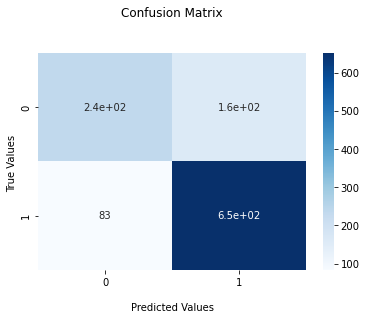

In [29]:
# Printing the metric of accuracy, precision, recall, f1, classification report and the confusion matrix
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test,y_pred))

ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('True Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

## LinearSVC Result Test Examples

In [30]:
# Testing some sentences from dataset's text that is Accept
svcpipe.predict(["Gaussian Process Behaviour in Wide Deep Neural Networks. Whilst deep neural networks have shown great empirical success, there is still much work to be done to understand their theoretical properties. In this paper, we study the relationship between Gaussian processes with a recursive kernel definition and random wide fully connected feedforward networks with more than one hidden layer. We exhibit limiting procedures under which finite deep networks will converge in distribution to the corresponding Gaussian process. To evaluate convergence rates empirically, we use maximum mean discrepancy. We then exhibit situations where existing Bayesian deep networks are close to Gaussian processes in terms of the key quantities of interest. Any Gaussian process has a flat representation. Since this behaviour may be undesirable in certain situations we discuss ways in which it might be prevented.. - Summary The paper is well written and proves how deep, wide, fully connected NNs are equivalent to GPs in the limit."])

array(['Accept'], dtype=object)

In [31]:
# Testing some sentences from dataset's text that is Reject
svcpipe.predict(["Gradient Enrichment (MBPGE), is tested on a collection of benchmark tests including simulated robotic locomotion. We compare our approach to plain model-free algorithms and a model-based one. Our evaluation shows that MBPGE leads to higher learning rates in an early training stage and an improved asymptotic behaviour.. This paper focuses on model based reinforcement learning (RL). Specifically, the authors consider the setting of combining model based and model free RL algorithms by using the learned dynamics model to generate new data for training the model free algorithm. In order to capture the uncertainty of the environment and the model, the author applied Baysian neural network to learn the dynamics of the environment."])

array(['Reject'], dtype=object)

In [32]:
# Testing the some sentences from dataset's text that is Accept
svcpipe.predict(["Multi-Agent Interactions Modeling with Correlated Policies. In multi-agent systems, complex interacting behaviors arise due to heavy correlations among agents. However, prior works on modeling multi-agent interactions from demonstrations have largely been constrained by assuming the independence among policies and their reward structures. In this paper, we cast the multi-agent interactions modeling problem into a multi-agent imitation learning framework with explicit modeling of correlated policies by approximating opponentsâ€™ policies. Consequently, we develop a Decentralized Adversarial Imitation Learning algorithm with Correlated policies (CoDAIL), which allows for decentralized training and execution."])

array(['Accept'], dtype=object)

## LogisticRegression Evaluation

In [33]:
# Use LogisticRegression creating the model and pipeline
tfidf = TfidfVectorizer(tokenizer = textcleaner)
lgr = LogisticRegression()

lr = [('tfidf',tfidf),('clf', lgr)]
lrpipe = Pipeline(lr)

In [34]:
# Training the model
lrpipe.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function textcleaner at 0x000001962C8BC1F0>)),
                ('clf', LogisticRegression())])

In [35]:
# Testing on the test dataset
y_pred = lrpipe.predict(X_test)

Accuracy: 0.7221238938053097
Classification Report: 
              precision    recall  f1-score   support

      Accept       0.79      0.28      0.41       395
      Reject       0.71      0.96      0.82       735

    accuracy                           0.72      1130
   macro avg       0.75      0.62      0.62      1130
weighted avg       0.74      0.72      0.68      1130

Confusion Matrix: 
[[110 285]
 [ 29 706]]


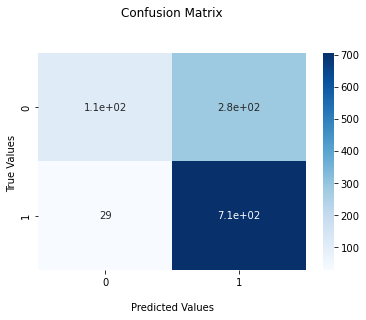

In [36]:
# Printing the metric of accuracy, precision, recall, f1, classification report and the confusion matrix
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test,y_pred))

ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('True Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

## LogisticRegression Result Test Examples

In [37]:
# Testing the some sentences from dataset's text that is Accept
lrpipe.predict(["Gaussian Process Behaviour in Wide Deep Neural Networks. Whilst deep neural networks have shown great empirical success, there is still much work to be done to understand their theoretical properties. In this paper, we study the relationship between Gaussian processes with a recursive kernel definition and random wide fully connected feedforward networks with more than one hidden layer. We exhibit limiting procedures under which finite deep networks will converge in distribution to the corresponding Gaussian process. To evaluate convergence rates empirically, we use maximum mean discrepancy. We then exhibit situations where existing Bayesian deep networks are close to Gaussian processes in terms of the key quantities of interest. Any Gaussian process has a flat representation. Since this behaviour may be undesirable in certain situations we discuss ways in which it might be prevented.. - Summary The paper is well written and proves how deep, wide, fully connected NNs are equivalent to GPs in the limit."])

array(['Accept'], dtype=object)

In [38]:
# Testing the some sentences from dataset's text that is Reject
lrpipe.predict(["Gradient Enrichment (MBPGE), is tested on a collection of benchmark tests including simulated robotic locomotion. We compare our approach to plain model-free algorithms and a model-based one. Our evaluation shows that MBPGE leads to higher learning rates in an early training stage and an improved asymptotic behaviour.. This paper focuses on model based reinforcement learning (RL). Specifically, the authors consider the setting of combining model based and model free RL algorithms by using the learned dynamics model to generate new data for training the model free algorithm. In order to capture the uncertainty of the environment and the model, the author applied Baysian neural network to learn the dynamics of the environment."])

array(['Reject'], dtype=object)

In [39]:
# Testing the some sentences from dataset's text that is Accept
lrpipe.predict(["Multi-Agent Interactions Modeling with Correlated Policies. In multi-agent systems, complex interacting behaviors arise due to heavy correlations among agents. However, prior works on modeling multi-agent interactions from demonstrations have largely been constrained by assuming the independence among policies and their reward structures. In this paper, we cast the multi-agent interactions modeling problem into a multi-agent imitation learning framework with explicit modeling of correlated policies by approximating opponentsâ€™ policies. Consequently, we develop a Decentralized Adversarial Imitation Learning algorithm with Correlated policies (CoDAIL), which allows for decentralized training and execution."])

array(['Accept'], dtype=object)

# 3. Multiclass Classification to Implement Review Score

## Data Cleaning and Preperation

In [40]:
# Take the three main features for the data preperation
DT2 = PRW[["text", "review_score", "acceptance_status"]]
DT2.head()

,text,review_score,acceptance_status
0,Predicting Medications from Diagnostic Codes w...,6.0,Accept
1,Unrestricted Adversarial Examples via Semantic...,6.0,Accept
2,#. #. #. #,6.0,Accept
3,Sufficient Conditions for Robustness to Advers...,5.0,Reject
4,Unsupervised Learning of the Set of Local Maxi...,8.0,Accept


In [41]:
# Check the shape of data
print(DT2.shape)

# Check the different value amount in review_score
DT2['review_score'].value_counts()

(6119, 3)


 6.0     1566
 3.0     1410
 5.0      630
 7.0      627
 4.0      623
 8.0      504
 1.0      463
-1.0      169
 9.0       62
 2.0       62
 10.0       3
Name: review_score, dtype: int64

In [42]:
# Check the percentage of each value take space in the whole data
print("Class Distribution:")
print(DT2["review_score"].value_counts() / len(DT2["review_score"]))

Class Distribution:
 6.0     0.255924
 3.0     0.230430
 5.0     0.102958
 7.0     0.102468
 4.0     0.101814
 8.0     0.082366
 1.0     0.075666
-1.0     0.027619
 9.0     0.010132
 2.0     0.010132
 10.0    0.000490
Name: review_score, dtype: float64


In [43]:
# Based on the requirement, there shouldn't have the review_score value of -1
# Before make the decision on this value, check the detail on all -1 values
DT2.loc[DT2['review_score'] == -1]

,text,review_score,acceptance_status
23,iWGAN: an Autoencoder WGAN for Inference. Gene...,-1.0,Reject
96,VECTORIZATION METHODS IN RECOMMENDER SYSTEM. T...,-1.0,Reject
160,Recovering the Lowest Layer of Deep Networks w...,-1.0,Reject
162,Learning Features of Music From Scratch. This ...,-1.0,Accept
169,Distilled embedding: non-linear embedding fact...,-1.0,Reject
...,...,...,...
5977,Beyond Winning and Losing: Modeling Human Moti...,-1.0,Reject
6017,UNSUPERVISED MONOCULAR DEPTH ESTIMATION WITH C...,-1.0,Reject
6024,And the Bit Goes Down: Revisiting the Quantiza...,-1.0,NaN
6027,AdaGAN: Adaptive GAN for Many-to-Many Non-Para...,-1.0,Reject


In [44]:
# According to the information from the study above, the -1 values just stand less amount in entire data
# And then, most of its information is rejected in acceptance_status
# Therefore, it possible to drop the -1 value from the data
DT2.drop(DT2[DT2['review_score'] == -1].index, inplace = True)
# Display the shape of the data after dropping -1 values
DT2.shape

C:\Users\Soraneat\anaconda3\envs\COMP1832_Lab\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(5950, 3)

In [45]:
# Take the two main features for this stage implementation
DT2=DT2[["text", "review_score"]]
DT2.head()

,text,review_score
0,Predicting Medications from Diagnostic Codes w...,6.0
1,Unrestricted Adversarial Examples via Semantic...,6.0
2,#. #. #. #,6.0
3,Sufficient Conditions for Robustness to Advers...,5.0
4,Unsupervised Learning of the Set of Local Maxi...,8.0


In [46]:
# Check if there any null value (Missing value)
DT2.isnull().sum()

text            83
review_score     0
dtype: int64

In [47]:
# Check and Display the missing value
NDT2 = DT2[DT2.isnull().any(axis=1)]
NDT2

,text,review_score
241,NaN,3.0
395,NaN,3.0
455,NaN,7.0
575,NaN,6.0
581,NaN,6.0
...,...,...
5670,NaN,1.0
5674,NaN,7.0
5711,NaN,6.0
5827,NaN,5.0


In [48]:
# Drop all the missing value
DT2 = DT2.dropna()
# Display the final data that use for the next step
print(DT2)

                                                   text  review_score
0     Predicting Medications from Diagnostic Codes w...           6.0
1     Unrestricted Adversarial Examples via Semantic...           6.0
2                                            #. #. #. #           6.0
3     Sufficient Conditions for Robustness to Advers...           5.0
4     Unsupervised Learning of the Set of Local Maxi...           8.0
...                                                 ...           ...
6114  PixelNN: Example-based Image Synthesis. We pre...           7.0
6115  Wasserstein Robust Reinforcement Learning. Rei...           3.0
6116  Learning to Augment Influential Data. Data aug...           6.0
6117  The Incredible Shrinking Neural Network: New P...           3.0
6118  Pre-trained Contextual Embedding of Source Cod...           6.0

[5867 rows x 2 columns]


## Text Preprocessing

In [49]:
# Load the english pipeline
nlp = en_core_web_sm.load()

In [50]:
# Get and Display all the stopwords
stopwords = list(STOP_WORDS)
print(stopwords)

['wherein', 'really', 'any', 'among', 'thus', 'becomes', 'cannot', 'all', 'upon', 'been', 'latter', 'below', 'again', 'enough', 'former', 'off', 'nowhere', 'doing', 'hundred', 'see', 'had', 'my', 'may', 'whole', '’m', 'yours', 'never', 'give', 'the', 'except', 'otherwise', 'everything', 'in', 'moreover', 'until', 'under', 'whence', 'must', 'most', 'first', 'none', 'would', 'could', 'four', 'you', 'beyond', 'onto', 'beside', 'seeming', 'his', 'do', 'noone', 'but', 'anyhow', 'are', 'he', 'us', 'such', 'were', 'when', 'herein', 'therefore', 'a', 'not', 'twenty', 'everyone', 'since', 'she', 'often', 'then', '‘ve', 'is', 'nevertheless', 'although', 'became', 'more', 'if', 'nobody', 'made', 'ca', 'at', 'both', 'keep', 'might', 'very', 'what', 'full', 'some', 'much', 'call', 'anyway', 'once', 'get', '‘re', 'throughout', 'together', 'towards', 'sixty', 'empty', 'than', 'something', 'where', 'up', 'these', 'seems', 'amount', 'him', 'seemed', 'please', 'another', 'with', 'hers', 'so', 'still', '

In [51]:
# Get and Display the punctuation
punct = string.punctuation
print(punct)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [52]:
# Function for the text cleaning
def textcleaner(phrase):
  t = nlp(phrase)
  tokens = []
  for token in t:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  clean_text = []
  for token in tokens:
    if token not in punct and token not in stopwords:
      clean_text.append(token)
  return clean_text

In [53]:
# Test example for the textcleaner function
textcleaner("This the another test for the text_cleaner.")

['test', 'text_cleaner']

## Split Data

In [54]:
# Spillting the train and test data
X = DT2['text']
y = DT2['review_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Display the shape of each train and test data
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)
print("Y_train shape: ",y_train.shape)
print("Y_test shape: ",y_test.shape)

X_train shape:  (4693,)
X_test shape:  (1174,)
Y_train shape:  (4693,)
Y_test shape:  (1174,)


## LinearSVC Evalaution

In [55]:
# Use Linear SVC creating the model and pipeline
tfidf = TfidfVectorizer(tokenizer = textcleaner)
svm = LinearSVC()

svc1 = [('tfidf',tfidf),('svm',svm)]
svcpipe1 = Pipeline(svc1)

In [56]:
# Training the model
svcpipe1.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function textcleaner at 0x000001962C88D700>)),
                ('svm', LinearSVC())])

In [57]:
# Testing on the test dataset
y_pred = svcpipe1.predict(X_test)

Accuracy: 0.35008517887563884
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.34      0.19      0.24        90
         2.0       0.33      0.07      0.11        15
         3.0       0.41      0.50      0.45       289
         4.0       0.31      0.28      0.29       122
         5.0       0.22      0.15      0.18       132
         6.0       0.36      0.50      0.42       290
         7.0       0.33      0.27      0.30       114
         8.0       0.27      0.18      0.21       106
         9.0       0.33      0.06      0.11        16

    accuracy                           0.35      1174
   macro avg       0.32      0.24      0.26      1174
weighted avg       0.34      0.35      0.33      1174

Confusion Matrix: 
[[ 17   0  47   5   2  15   1   3   0]
 [  0   1   2   5   3   2   2   0   0]
 [ 18   1 144  14  13  77  10  12   0]
 [  1   1  33  34  18  25   8   2   0]
 [  5   0  25  23  20  42  14   3   0]
 [  7   0  61  18  17 144  

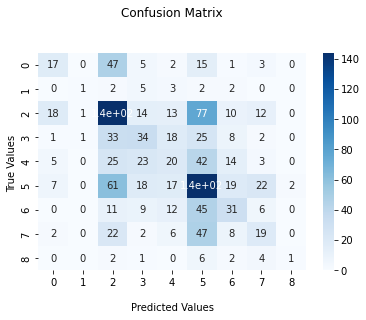

In [58]:
# Printing the metric of accuracy, precision, recall, f1, classification report and the confusion matrix
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test,y_pred))

ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('True Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

## LinearSVC Result Test Examples

In [59]:
# Testing some sentences from dataset's text that review score is 10
svcpipe1.predict(["GENERATING HIGH FIDELITY IMAGES WITH SUBSCALE PIXEL NETWORKS AND MULTIDIMENSIONAL UPSCALING. The unconditional generation of high fidelity images is a longstanding benchmark for testing the performance of image decoders. Autoregressive image models have been able to generate small images unconditionally, but the extension of these methods to large images where fidelity can be more readily assessed has remained an open problem. Among the major challenges are the capacity to encode the vast previous context and the sheer difficulty of learning a distribution that preserves both global semantic coherence and exactness of detail. To address the former challenge, we propose the Subscale Pixel Network (SPN), a conditional decoder architecture that generates an image as a sequence of image slices of equal size. The SPN compactly captures image-wide spatial dependencies and requires a fraction of the memory and the computation."])

array([9.])

In [60]:
# Testing some sentences from dataset's text that review score is 6
svcpipe1.predict(["Espresso: Efficient Forward Propagation for Binary Deep Neural Networks. There are many applications scenarios for which the computational performance and memory footprint of the prediction phase of Deep Neural Networks (DNNs) need to be optimized. Binary Deep Neural Networks (BDNNs) have been shown to be an effective way of achieving this objective. In this paper, we show how Convolutional Neural Networks (CNNs) can be implemented using binary representations. Espresso is a compact, yet powerful library written in C/CUDA that features all the functionalities required for the forward propagation of CNNs, in a binary file less than 400KB, without any external dependencies. Although it is mainly designed to take advantage of massive GPU parallelism, Espresso also provides an equivalent CPU implementation for CNNs. Espresso provides special convolutional and dense layers for BCNNs, leveraging bit-packing and bit-wise computations for efficient execution."])

array([6.])

In [61]:
# Testing some sentences from dataset's text that review score is 1
svcpipe1.predict(["Equation 4. How is s_t sampled? 4. Section 4 questions a. 4.1 says discriminator â€œmaximizes the divergenceâ€. This doesnâ€™t seem correct. b. f is referred to as state-value. This doesnâ€™t seem correct. c. Shouldnâ€™t the -1 term in Equation 8 disappear under expectation? d. Donâ€™t understand how second line of Equation 11 is arrived at. There are quite a few other sources of mathematically imprecise writing that I noticed. I would recommend the authors to be more robust in their presentation.. The paper proposed a refined AIRL method to deal with the reward ambiguity problem in image captioning, wherein the main idea is to refine the loss function in word level instead in sentence level, and introduce a conditional term in the loss function to mitigate mode collapse problem."])

array([1.])

## Logistic Regression Evaluation

In [62]:
# Use Logistic Regression creating the model and pipeline
tfidf = TfidfVectorizer(tokenizer = textcleaner)
lgr = LogisticRegression()

lr1 = [('tfidf',tfidf),('clf', lgr)]
lrpipe1 = Pipeline(lr1)

In [63]:
# Training the model
lrpipe1.fit(X_train,y_train)

C:\Users\Soraneat\anaconda3\envs\COMP1832_Lab\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function textcleaner at 0x000001962C88D700>)),
                ('clf', LogisticRegression())])

In [64]:
# Testing on the test dataset
y_pred = lrpipe1.predict(X_test)

Accuracy: 0.33475298126064734
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.50      0.04      0.08        90
         2.0       0.00      0.00      0.00        15
         3.0       0.38      0.56      0.45       289
         4.0       0.39      0.09      0.15       122
         5.0       0.27      0.05      0.08       132
         6.0       0.30      0.67      0.42       290
         7.0       0.31      0.10      0.15       114
         8.0       0.56      0.05      0.09       106
         9.0       0.00      0.00      0.00        16

    accuracy                           0.33      1174
   macro avg       0.30      0.17      0.16      1174
weighted avg       0.36      0.33      0.27      1174

Confusion Matrix: 
[[  4   0  58   1   1  26   0   0   0]
 [  0   0   7   1   1   5   1   0   0]
 [  2   0 161   5   2 114   2   3   0]
 [  0   0  50  11   6  50   5   0   0]
 [  0   0  28   1   6  91   6   0   0]
 [  1   0  79   7   1 195  

C:\Users\Soraneat\anaconda3\envs\COMP1832_Lab\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Soraneat\anaconda3\envs\COMP1832_Lab\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Soraneat\anaconda3\envs\COMP1832_Lab\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

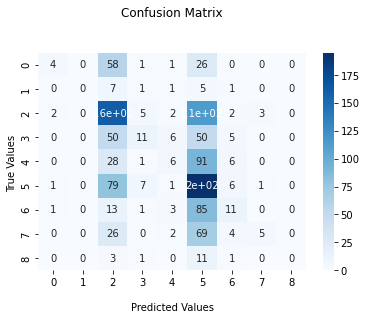

In [65]:
# Printing the metric of accuracy, precision, recall, f1, classification report and the confusion matrix
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test,y_pred))

ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('True Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

## Logistic Regression Result Test Examples

In [66]:
# Testing some sentences from dataset's text that review score is 10
lrpipe1.predict(["GENERATING HIGH FIDELITY IMAGES WITH SUBSCALE PIXEL NETWORKS AND MULTIDIMENSIONAL UPSCALING. The unconditional generation of high fidelity images is a longstanding benchmark for testing the performance of image decoders. Autoregressive image models have been able to generate small images unconditionally, but the extension of these methods to large images where fidelity can be more readily assessed has remained an open problem. Among the major challenges are the capacity to encode the vast previous context and the sheer difficulty of learning a distribution that preserves both global semantic coherence and exactness of detail. To address the former challenge, we propose the Subscale Pixel Network (SPN), a conditional decoder architecture that generates an image as a sequence of image slices of equal size. The SPN compactly captures image-wide spatial dependencies and requires a fraction of the memory and the computation."])

array([6.])

In [67]:
# Testing some sentences from dataset's text that review score is 6
lrpipe1.predict(["Espresso: Efficient Forward Propagation for Binary Deep Neural Networks. There are many applications scenarios for which the computational performance and memory footprint of the prediction phase of Deep Neural Networks (DNNs) need to be optimized. Binary Deep Neural Networks (BDNNs) have been shown to be an effective way of achieving this objective. In this paper, we show how Convolutional Neural Networks (CNNs) can be implemented using binary representations. Espresso is a compact, yet powerful library written in C/CUDA that features all the functionalities required for the forward propagation of CNNs, in a binary file less than 400KB, without any external dependencies. Although it is mainly designed to take advantage of massive GPU parallelism, Espresso also provides an equivalent CPU implementation for CNNs. Espresso provides special convolutional and dense layers for BCNNs, leveraging bit-packing and bit-wise computations for efficient execution."])

array([6.])

In [68]:
# Testing some sentences from dataset's text that review score is 1
lrpipe1.predict(["Equation 4. How is s_t sampled? 4. Section 4 questions a. 4.1 says discriminator â€œmaximizes the divergenceâ€. This doesnâ€™t seem correct. b. f is referred to as state-value. This doesnâ€™t seem correct. c. Shouldnâ€™t the -1 term in Equation 8 disappear under expectation? d. Donâ€™t understand how second line of Equation 11 is arrived at. There are quite a few other sources of mathematically imprecise writing that I noticed. I would recommend the authors to be more robust in their presentation.. The paper proposed a refined AIRL method to deal with the reward ambiguity problem in image captioning, wherein the main idea is to refine the loss function in word level instead in sentence level, and introduce a conditional term in the loss function to mitigate mode collapse problem."])

array([3.])

# 4. Multiclass Classification to Implement Review Score (Another Implement Way)

### The accuracy of the review score is poor since some variables are used less frequently in the dataset, which can effect the prediction. Even though in both methodologies, as seen above, only half of the example outcomes were correct.

### There is a wonderful technique to execute it in order to have a better performance at this point. It would be more effective to divide the score numbers from 1 to 10 into two sections rather than use all of them. For example, "0" is 1 to 5, and "1" is 6 to 10.

## Data Cleaning and Preperation

In [69]:
# As this section is same as the last section, it possible to directly use the above dataset that perfectly prepared
# Take the two main features for this stage implementation
DT3=DT2[["text", "review_score"]]
DT3

,text,review_score
0,Predicting Medications from Diagnostic Codes w...,6.0
1,Unrestricted Adversarial Examples via Semantic...,6.0
2,#. #. #. #,6.0
3,Sufficient Conditions for Robustness to Advers...,5.0
4,Unsupervised Learning of the Set of Local Maxi...,8.0
...,...,...
6114,PixelNN: Example-based Image Synthesis. We pre...,7.0
6115,Wasserstein Robust Reinforcement Learning. Rei...,3.0
6116,Learning to Augment Influential Data. Data aug...,6.0
6117,The Incredible Shrinking Neural Network: New P...,3.0


In [70]:
# Check if there any null value (Missing value)
DT3.isnull().sum()

text            0
review_score    0
dtype: int64

In [71]:
# Function to divide the value of review_score in to two main parts
def mappingfunction(x):
    if x < 6:
        return 0
    return 1

# Add the new column "score" for divided value
DT3["score"] = DT3["review_score"].apply(lambda x: mappingfunction(x))
DT3.head(5)

,text,review_score,score
0,Predicting Medications from Diagnostic Codes w...,6.0,1
1,Unrestricted Adversarial Examples via Semantic...,6.0,1
2,#. #. #. #,6.0,1
3,Sufficient Conditions for Robustness to Advers...,5.0,0
4,Unsupervised Learning of the Set of Local Maxi...,8.0,1


In [72]:
# Display this final data that use in the next step
print(DT3)

                                                   text  review_score  score
0     Predicting Medications from Diagnostic Codes w...           6.0      1
1     Unrestricted Adversarial Examples via Semantic...           6.0      1
2                                            #. #. #. #           6.0      1
3     Sufficient Conditions for Robustness to Advers...           5.0      0
4     Unsupervised Learning of the Set of Local Maxi...           8.0      1
...                                                 ...           ...    ...
6114  PixelNN: Example-based Image Synthesis. We pre...           7.0      1
6115  Wasserstein Robust Reinforcement Learning. Rei...           3.0      0
6116  Learning to Augment Influential Data. Data aug...           6.0      1
6117  The Incredible Shrinking Neural Network: New P...           3.0      0
6118  Pre-trained Contextual Embedding of Source Cod...           6.0      1

[5867 rows x 3 columns]


In [73]:
# Check if there any null value (Missing value)
DT3.isnull().sum()

text            0
review_score    0
score           0
dtype: int64

## Text Preprocessing

In [74]:
# Load the english pipeline
nlp = en_core_web_sm.load()

In [75]:
# Get and Display all the stopwords
stopwords = list(STOP_WORDS)
print(stopwords)

['wherein', 'really', 'any', 'among', 'thus', 'becomes', 'cannot', 'all', 'upon', 'been', 'latter', 'below', 'again', 'enough', 'former', 'off', 'nowhere', 'doing', 'hundred', 'see', 'had', 'my', 'may', 'whole', '’m', 'yours', 'never', 'give', 'the', 'except', 'otherwise', 'everything', 'in', 'moreover', 'until', 'under', 'whence', 'must', 'most', 'first', 'none', 'would', 'could', 'four', 'you', 'beyond', 'onto', 'beside', 'seeming', 'his', 'do', 'noone', 'but', 'anyhow', 'are', 'he', 'us', 'such', 'were', 'when', 'herein', 'therefore', 'a', 'not', 'twenty', 'everyone', 'since', 'she', 'often', 'then', '‘ve', 'is', 'nevertheless', 'although', 'became', 'more', 'if', 'nobody', 'made', 'ca', 'at', 'both', 'keep', 'might', 'very', 'what', 'full', 'some', 'much', 'call', 'anyway', 'once', 'get', '‘re', 'throughout', 'together', 'towards', 'sixty', 'empty', 'than', 'something', 'where', 'up', 'these', 'seems', 'amount', 'him', 'seemed', 'please', 'another', 'with', 'hers', 'so', 'still', '

In [76]:
# Get and Display the punctuation
punct = string.punctuation
print(punct)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [77]:
# Function for the text cleaning
def textcleaner(phrase):
  t = nlp(phrase)
  tokens = []
  for token in t:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  clean_text = []
  for token in tokens:
    if token not in punct and token not in stopwords:
      clean_text.append(token)
  return clean_text

In [78]:
# Test example for the textcleaner function
textcleaner("This the another test for the text_cleaner again.")

['test', 'text_cleaner']

## Split Data

In [79]:
# Spillting the train and test data
X = DT3['text']
y = DT3['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Display the shape of each train and test data
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)
print("Y_train shape: ",y_train.shape)
print("Y_test shape: ",y_test.shape)

X_train shape:  (4693,)
X_test shape:  (1174,)
Y_train shape:  (4693,)
Y_test shape:  (1174,)


## LinearSVC Evaluation

In [80]:
# Use Linear SVC creating the model and pipeline
tfidf = TfidfVectorizer(tokenizer = textcleaner)
svm = LinearSVC()

svc2 = [('tfidf',tfidf),('svm',svm)]
svcpipe2 = Pipeline(svc2)

In [81]:
# Training the model
svcpipe2.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function textcleaner at 0x000001963681CCA0>)),
                ('svm', LinearSVC())])

In [82]:
# Testing on the test dataset
y_pred = svcpipe2.predict(X_test)

Accuracy: 0.7257240204429302
Classification Report: 
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       618
           1       0.73      0.68      0.70       556

    accuracy                           0.73      1174
   macro avg       0.73      0.72      0.72      1174
weighted avg       0.73      0.73      0.72      1174

Confusion Matrix: 
[[476 142]
 [180 376]]


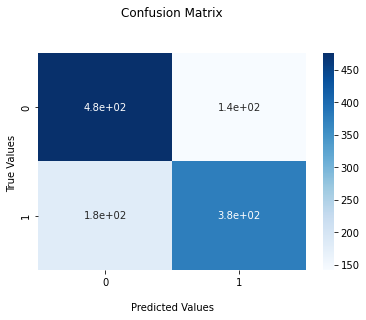

In [83]:
# Printing the metric of accuracy, precision, recall, f1, classification report and the confusion matrix
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test,y_pred))

ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('True Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

## LinearSVC Result Test Examples

In [84]:
# Testing some sentences from dataset's text that review score is 10
svcpipe2.predict(["GENERATING HIGH FIDELITY IMAGES WITH SUBSCALE PIXEL NETWORKS AND MULTIDIMENSIONAL UPSCALING. The unconditional generation of high fidelity images is a longstanding benchmark for testing the performance of image decoders. Autoregressive image models have been able to generate small images unconditionally, but the extension of these methods to large images where fidelity can be more readily assessed has remained an open problem. Among the major challenges are the capacity to encode the vast previous context and the sheer difficulty of learning a distribution that preserves both global semantic coherence and exactness of detail. To address the former challenge, we propose the Subscale Pixel Network (SPN), a conditional decoder architecture that generates an image as a sequence of image slices of equal size. The SPN compactly captures image-wide spatial dependencies and requires a fraction of the memory and the computation."])

array([1], dtype=int64)

In [85]:
# Testing some sentences from dataset's text that review score is 6
svcpipe2.predict(["Espresso: Efficient Forward Propagation for Binary Deep Neural Networks. There are many applications scenarios for which the computational performance and memory footprint of the prediction phase of Deep Neural Networks (DNNs) need to be optimized. Binary Deep Neural Networks (BDNNs) have been shown to be an effective way of achieving this objective. In this paper, we show how Convolutional Neural Networks (CNNs) can be implemented using binary representations. Espresso is a compact, yet powerful library written in C/CUDA that features all the functionalities required for the forward propagation of CNNs, in a binary file less than 400KB, without any external dependencies. Although it is mainly designed to take advantage of massive GPU parallelism, Espresso also provides an equivalent CPU implementation for CNNs. Espresso provides special convolutional and dense layers for BCNNs, leveraging bit-packing and bit-wise computations for efficient execution."])

array([1], dtype=int64)

In [86]:
# Testing some sentences from dataset's text that review score is 1
svcpipe2.predict(["Equation 4. How is s_t sampled? 4. Section 4 questions a. 4.1 says discriminator â€œmaximizes the divergenceâ€. This doesnâ€™t seem correct. b. f is referred to as state-value. This doesnâ€™t seem correct. c. Shouldnâ€™t the -1 term in Equation 8 disappear under expectation? d. Donâ€™t understand how second line of Equation 11 is arrived at. There are quite a few other sources of mathematically imprecise writing that I noticed. I would recommend the authors to be more robust in their presentation.. The paper proposed a refined AIRL method to deal with the reward ambiguity problem in image captioning, wherein the main idea is to refine the loss function in word level instead in sentence level, and introduce a conditional term in the loss function to mitigate mode collapse problem."])

array([0], dtype=int64)

## LogisticReression Evaluation

In [87]:
# Use Logistic Reression creating the model and pipeline
tfidf = TfidfVectorizer(tokenizer = textcleaner)
lgr = LogisticRegression()

lr2 = [('tfidf',tfidf),('clf', lgr)]
lrpipe2 = Pipeline(lr2)

In [88]:
# Training the model
lrpipe2.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function textcleaner at 0x000001963681CCA0>)),
                ('clf', LogisticRegression())])

In [89]:
# Testing on the test dataset
y_pred = lrpipe2.predict(X_test)

Accuracy: 0.7086882453151618
Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.81      0.75       618
           1       0.74      0.60      0.66       556

    accuracy                           0.71      1174
   macro avg       0.71      0.70      0.70      1174
weighted avg       0.71      0.71      0.70      1174

Confusion Matrix: 
[[501 117]
 [225 331]]


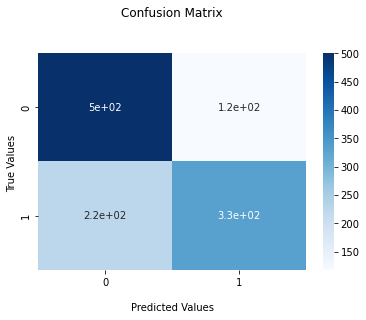

In [90]:
# Printing the metric of accuracy, precision, recall, f1, classification report and the confusion matrix
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test,y_pred))

ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('True Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

## LogisticReression Result Test Examples

In [91]:
# Testing some sentences from dataset's text that review score is 10
lrpipe2.predict(["GENERATING HIGH FIDELITY IMAGES WITH SUBSCALE PIXEL NETWORKS AND MULTIDIMENSIONAL UPSCALING. The unconditional generation of high fidelity images is a longstanding benchmark for testing the performance of image decoders. Autoregressive image models have been able to generate small images unconditionally, but the extension of these methods to large images where fidelity can be more readily assessed has remained an open problem. Among the major challenges are the capacity to encode the vast previous context and the sheer difficulty of learning a distribution that preserves both global semantic coherence and exactness of detail. To address the former challenge, we propose the Subscale Pixel Network (SPN), a conditional decoder architecture that generates an image as a sequence of image slices of equal size. The SPN compactly captures image-wide spatial dependencies and requires a fraction of the memory and the computation."])

array([1], dtype=int64)

In [92]:
# Testing some sentences from dataset's text that review score is 6
lrpipe2.predict(["Espresso: Efficient Forward Propagation for Binary Deep Neural Networks. There are many applications scenarios for which the computational performance and memory footprint of the prediction phase of Deep Neural Networks (DNNs) need to be optimized. Binary Deep Neural Networks (BDNNs) have been shown to be an effective way of achieving this objective. In this paper, we show how Convolutional Neural Networks (CNNs) can be implemented using binary representations. Espresso is a compact, yet powerful library written in C/CUDA that features all the functionalities required for the forward propagation of CNNs, in a binary file less than 400KB, without any external dependencies. Although it is mainly designed to take advantage of massive GPU parallelism, Espresso also provides an equivalent CPU implementation for CNNs. Espresso provides special convolutional and dense layers for BCNNs, leveraging bit-packing and bit-wise computations for efficient execution."])

array([1], dtype=int64)

In [93]:
# Testing some sentences from dataset's text that review score is 1
lrpipe2.predict(["Equation 4. How is s_t sampled? 4. Section 4 questions a. 4.1 says discriminator â€œmaximizes the divergenceâ€. This doesnâ€™t seem correct. b. f is referred to as state-value. This doesnâ€™t seem correct. c. Shouldnâ€™t the -1 term in Equation 8 disappear under expectation? d. Donâ€™t understand how second line of Equation 11 is arrived at. There are quite a few other sources of mathematically imprecise writing that I noticed. I would recommend the authors to be more robust in their presentation.. The paper proposed a refined AIRL method to deal with the reward ambiguity problem in image captioning, wherein the main idea is to refine the loss function in word level instead in sentence level, and introduce a conditional term in the loss function to mitigate mode collapse problem."])

array([0], dtype=int64)

## Plot For the Comparison Between 2 Models

               Metrics     1     2     3     4
0           Linear SVC  0.78  0.78  0.79  0.78
1  Logistic Regression  0.72  0.74  0.72  0.68


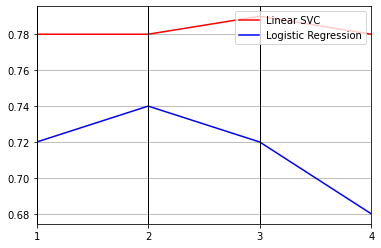

In [94]:
# Attribute of prediction acceptance status
# Create a dataframe of metric value in the 2 models, set as DF1
DF1= pd.DataFrame([['Linear SVC', 0.78, 0.78, 0.79, 0.78],
                   ['Logistic Regression', 0.72, 0.74, 0.72, 0.68]],
                  columns=['Metrics', 1, 2, 3, 4]) # 1 is Accuracy, 2 is Precision, 3 is Recall, and 4 is F1
# Print DF
print(DF1)

# Use parallel_coordinate, with different color for each model
pd.plotting.parallel_coordinates(DF1, 'Metrics', color=('#FF0000', '#0000FF'))

# Display and save the plot as picture
plt.savefig("attribute1_plot.jpg")
plt.show()

               Metrics     1     2     3     4
0           Linear SVC  0.72  0.73  0.73  0.72
1  Logistic Regression  0.70  0.71  0.71  0.70


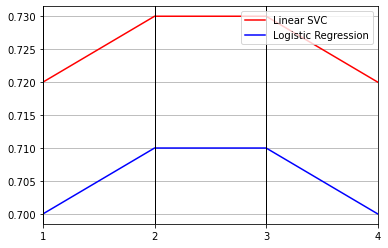

In [95]:
# Attribute of prediction review score
# Create a dataframe of metric value in the 2 models, set as DF2
DF2= pd.DataFrame([['Linear SVC', 0.72, 0.73, 0.73, 0.72],
                   ['Logistic Regression', 0.70, 0.71, 0.71, 0.70]],
                  columns=['Metrics', 1, 2, 3, 4]) # 1 is Accuracy, 2 is Precision, 3 is Recall, and 4 is F1
# Print DF
print(DF2)

# Use parallel_coordinate, with different color for each model
pd.plotting.parallel_coordinates(DF2, 'Metrics', color=('#FF0000', '#0000FF'))

# Display and save the plot as picture
plt.savefig("attribute2_plot.jpg")
plt.show()